<a href="https://colab.research.google.com/github/altz211/deeplearning/blob/main/Astronomy_CNN_using_Uncertainty_Prediction_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F
import os


# !pip install tensorboard

In [2]:
# Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Data acquisition
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Advanced Applied DL')

In [5]:
# Select and label data
spectra = np.load("/content/drive/MyDrive/Advanced Applied DL/spectra.npy")
spectra_length = spectra.shape[1]

# Define all label names: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]

# Load the labels
labels = np.load("/content/drive/MyDrive/Advanced Applied DL/labels.npy")

# Select only the three labels: t_eff, log_g, fe_h
labelNames = labelNames[-4:-1]  # This yields ['t_eff', 'log_g', 'fe_h']
labels = labels[:, -4:-1]
n_labels = labels.shape[1]

print("Spectra length:", spectra_length)
print("Selected label names:", labelNames)
print("Number of labels:", n_labels)

Spectra length: 16384
Selected label names: ['t_eff', 'log_g', 'fe_h']
Number of labels: 3


In [6]:
# Normalize the spectra by taking the log
spectra = np.log(np.maximum(spectra, 0.2))

In [7]:
# Standardize spectra (zero mean, unit variance)
spectra_mean = np.mean(spectra, axis=0)
spectra_std = np.std(spectra, axis=0)
spectra = (spectra - spectra_mean) / spectra_std

In [8]:
# Standardize labels
labels_mean = np.mean(labels, axis=0)
labels_std = np.std(labels, axis=0)
labels = (labels - labels_mean) / labels_std

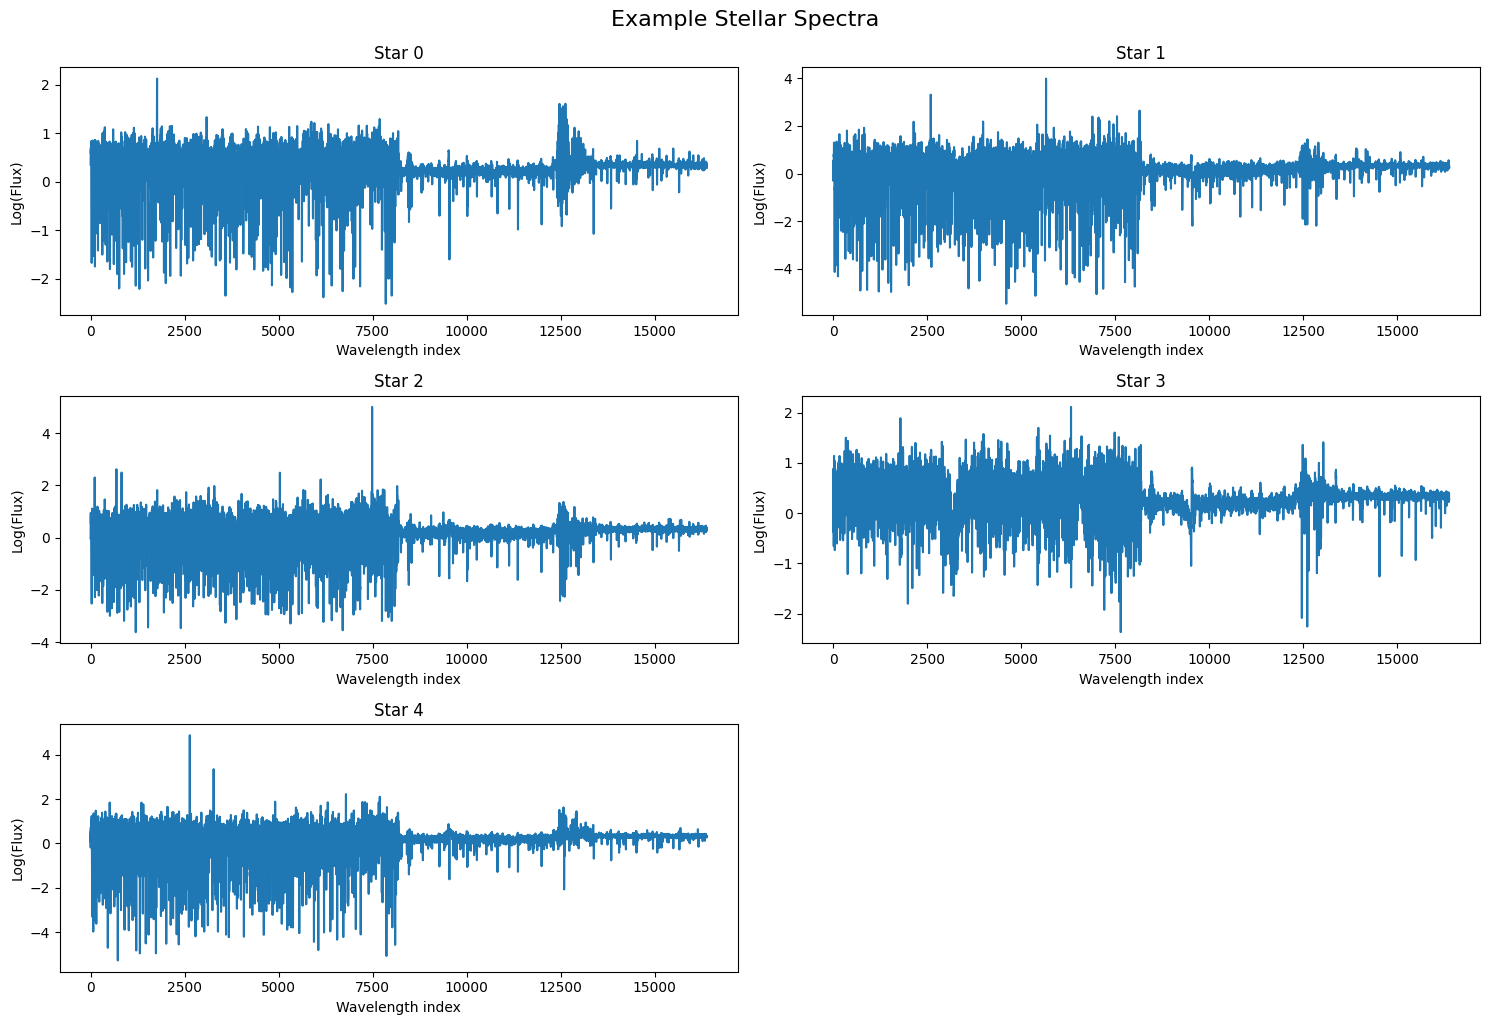

In [9]:
# Plot spectra
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(spectra[i])
    plt.title(f"Star {i}")
    plt.xlabel("Wavelength index")
    plt.ylabel("Log(Flux)")
    plt.tight_layout()

plt.suptitle("Example Stellar Spectra", fontsize=16, y=1.02)
plt.show()

In [10]:
spectra_tensor = torch.tensor(spectra, dtype=torch.float32).unsqueeze(1)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(spectra_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

sample_input, sample_target = next(iter(train_loader))
print(sample_target.shape)
print(sample_target[0])

torch.Size([32, 3])
tensor([-1.2150,  0.8577,  0.3045])


In [11]:
# CNN model
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.adapt_pool = nn.AdaptiveAvgPool1d(output_size=16)
        self.fc1 = nn.Linear(128 * 16, 128)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNNRegressor().to(device)
print(model)

CNNRegressor(
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adapt_pool): AdaptiveAvgPool1d(output_size=16)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [12]:
def nll_loss(pred, target):
    num_outputs = target.size(1)
    mu = pred[:, :num_outputs]
    log_var = pred[:, num_outputs:]
    var = torch.exp(log_var)
    nll = 0.5 * torch.log(2 * np.pi * var) + 0.5 * ((target - mu)**2) / var
    return torch.mean(nll)

In [13]:
criterion = nll_loss
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

n_epochs = 100
writer = SummaryWriter(log_dir="runs/my_model")
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nll_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    writer.add_scalar("Loss/train", epoch_train_loss, epoch)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = nll_loss(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    writer.add_scalar("Loss/val", epoch_val_loss, epoch)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    grid =torchvision.utils.make_grid(torch.randn(16,3, 32, 32))
    writer.add_image("Image", grid, epoch)

    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)

Epoch 1/100 | Train Loss: 1.1278 | Val Loss: 0.9764
Epoch 2/100 | Train Loss: 0.7626 | Val Loss: 0.5478
Epoch 3/100 | Train Loss: 0.4807 | Val Loss: 0.4335
Epoch 4/100 | Train Loss: 0.3973 | Val Loss: 0.4721
Epoch 5/100 | Train Loss: 0.3068 | Val Loss: 0.3542
Epoch 6/100 | Train Loss: 0.2431 | Val Loss: 0.3373
Epoch 7/100 | Train Loss: 0.2143 | Val Loss: 0.2520
Epoch 8/100 | Train Loss: 0.1645 | Val Loss: 0.1744
Epoch 9/100 | Train Loss: 0.1431 | Val Loss: 0.2465
Epoch 10/100 | Train Loss: 0.1259 | Val Loss: 0.1463
Epoch 11/100 | Train Loss: 0.0854 | Val Loss: 0.1000
Epoch 12/100 | Train Loss: 0.0631 | Val Loss: 0.2493
Epoch 13/100 | Train Loss: 0.0764 | Val Loss: 0.0433
Epoch 14/100 | Train Loss: 0.0236 | Val Loss: 0.1134
Epoch 15/100 | Train Loss: 0.0319 | Val Loss: 0.0225
Epoch 16/100 | Train Loss: 0.0064 | Val Loss: 0.0708
Epoch 17/100 | Train Loss: -0.0017 | Val Loss: -0.0043
Epoch 18/100 | Train Loss: -0.0365 | Val Loss: 0.0366
Epoch 19/100 | Train Loss: -0.0440 | Val Loss: 0.029

In [16]:
test_loader = val_loader

model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: -0.0281


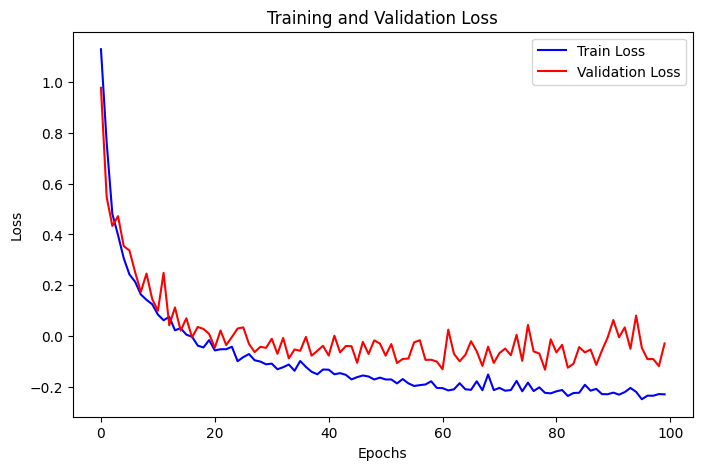

In [17]:
# Plot training and test loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [18]:
# Visualize predictions vs. true labels for the test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        preds = model(inputs)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

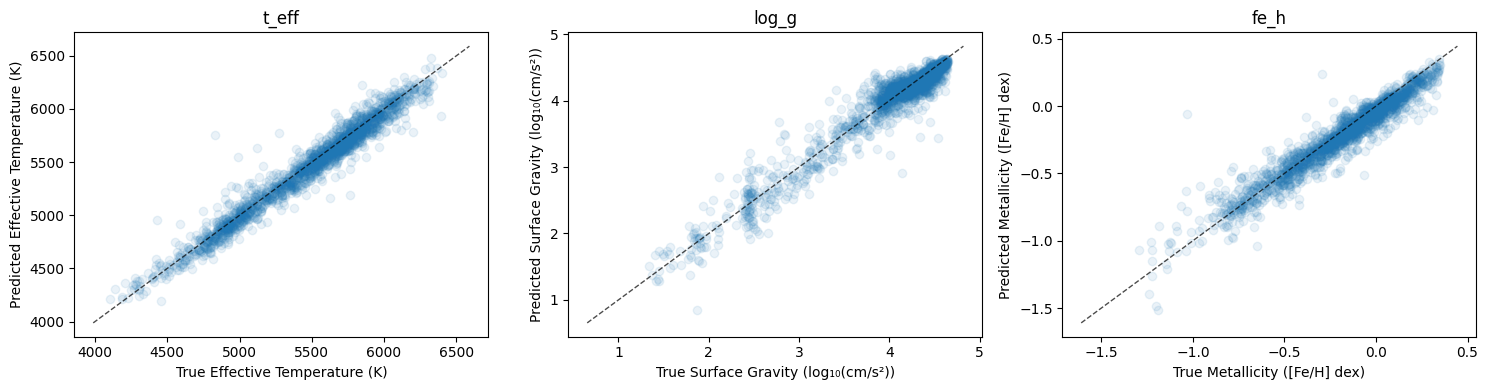

In [19]:

all_preds_means = all_preds[:, :3]
all_preds_unnorm = all_preds_means * labels_std + labels_mean
all_targets_unnorm = all_targets * labels_std + labels_mean
axis_labels = {
    "t_eff": "Effective Temperature (K)",
    "log_g": "Surface Gravity (log₁₀(cm/s²))",
    "fe_h": "Metallicity ([Fe/H] dex)"
}

plt.figure(figsize=(15, 4))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.scatter(all_targets_unnorm[:, i], all_preds_unnorm[:, i], alpha=0.09)
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]
    ax.plot(lims, lims, 'k--', linewidth=1, alpha=0.7)

    plt.xlabel(f"True {axis_labels[labelNames[i]]}")
    plt.ylabel(f"Predicted {axis_labels[labelNames[i]]}")
    plt.title(labelNames[i])
plt.tight_layout()
plt.show()


